# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import warnings
import pickle

# Load Data

In [2]:
df = pd.read_csv('ObesityDataSet1.csv')
print(df.shape)
df.head()

(1055, 17)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,31,1.87,128.87,yes,yes,2.96,3.00,Sometimes,yes,1.28,no,0.90,1.875,Sometimes,Automobile,Obesity_Type_II
1,Female,18,1.59,40.00,yes,yes,2.00,1.00,Frequently,no,1.00,no,0.00,2.000,no,Public_Transportation,Insufficient_Weight
2,Female,44 years,1.59,77.00,yes,yes,2.00,3.00,Sometimes,no,2.81,no,0.00,0.000,Sometimes,Automobile,Obesity_Type_I
3,Male,31,1.68,102.00,yes,yes,2.94,2.14,Sometimes,no,1.25,no,1.18,0.778,no,Public_Transportation,Obesity_Type_II
4,Male,22,1.74,75.00,yes,yes,3.00,3.00,Frequently,no,1.00,no,1.00,0.000,no,Automobile,Normal_Weight


Dataset ini berisi data profil individu dan kebiasaan sehari-hari terkait risiko obesitas.  
Target prediksi adalah `NObeyesedad` (tingkat obesitas), dengan fitur berupa demografi, riwayat keluarga, gaya hidup, konsumsi makanan, aktivitas fisik, dll


# EDA

## Cek Missing Value

In [3]:
print(df.isnull().sum())

Gender                             0
Age                                0
Height                             0
Weight                             0
family_history_with_overweight     0
FAVC                               0
FCVC                               0
NCP                                0
CAEC                              26
SMOKE                              0
CH2O                               0
SCC                                0
FAF                                0
TUE                               37
CALC                               0
MTRANS                             0
NObeyesdad                         0
dtype: int64


Terdapat beberapa missing value, disini saya akan menginputasinya dengan mean/median untuk numerikal(tergantung distribusinya), dan mode untuk kategorikal

## Missing Value Handling

### Numerical

Numerik dengan missing: ['TUE']


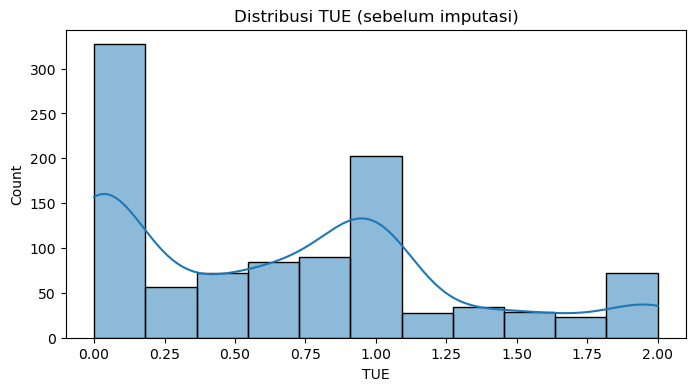

Mean: 0.677, Median: 0.673, Missing: 37
Imputasi kolom TUE dengan mean: 0.677 (skewness 0.58)


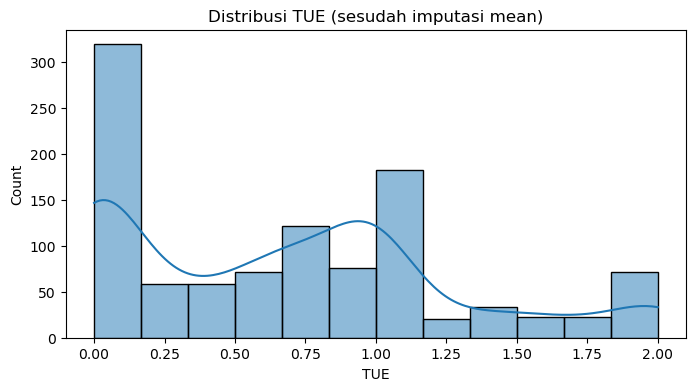

In [4]:
# Kolom numerik dengan missing value
num_missing = df.columns[df.isnull().sum() > 0].intersection(df.select_dtypes(include=[np.number]).columns)
print("Numerik dengan missing:", list(num_missing))

for col in num_missing:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribusi {col} (sebelum imputasi)')
    plt.show()
    print(f"Mean: {df[col].mean():.3f}, Median: {df[col].median():.3f}, Missing: {df[col].isnull().sum()}")

    ## Pilih Median/Mean
    skew = df[col].skew()
    if abs(skew) > 1:
        fill_value = df[col].median()
        imputasi = 'median'
    else:
        fill_value = df[col].mean()
        imputasi = 'mean'
    print(f"Imputasi kolom {col} dengan {imputasi}: {fill_value:.3f} (skewness {skew:.2f})")
    df[col] = df[col].fillna(fill_value)

    plt.figure(figsize=(8,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribusi {col} (sesudah imputasi {imputasi})')
    plt.show()


### Categorical

Kategorikal dengan missing: ['CAEC']


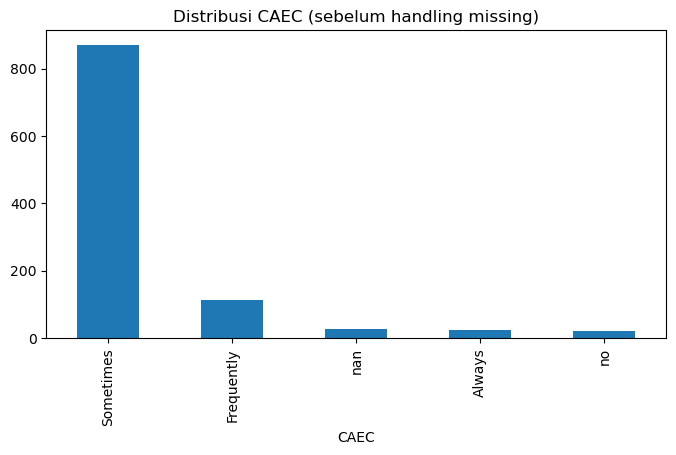

Missing: 26 dari 1055 data, Mode: Sometimes
Drop row pada kolom CAEC yang missing, karena sangat imbalance.


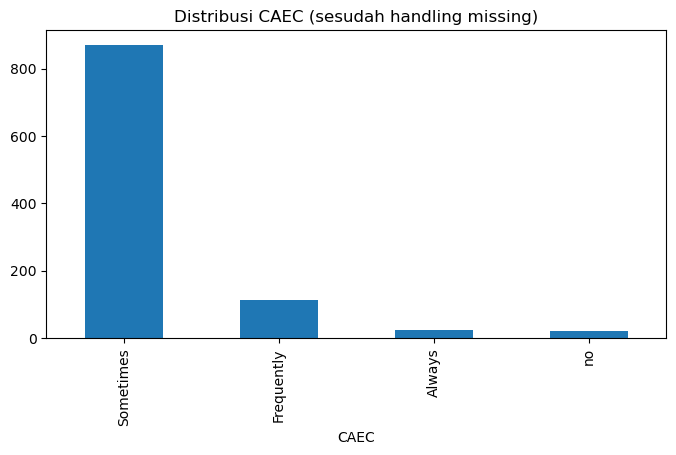

In [5]:
# Kolom kategorikal dengan missing value
cat_missing = df.columns[df.isnull().sum() > 0].intersection(df.select_dtypes(include='object').columns)
print("Kategorikal dengan missing:", list(cat_missing))

for col in cat_missing:
    plt.figure(figsize=(8,4))
    df[col].value_counts(dropna=False).plot(kind='bar')
    plt.title(f'Distribusi {col} (sebelum handling missing)')
    plt.show()

    n_missing = df[col].isnull().sum()
    n_total = df.shape[0]
    print(f"Missing: {n_missing} dari {n_total} data, Mode: {df[col].mode()[0]}")
    largest_count = df[col].value_counts().max()
    if (largest_count / (n_total - n_missing) > 0.7) and (n_missing / n_total < 0.05):
        print(f"Drop row pada kolom {col} yang missing, karena sangat imbalance.")
        df = df[df[col].notnull()].copy()
    else:
        mode_val = df[col].mode().iloc[0]
        print(f"Imputasi kolom {col} dengan mode: '{mode_val}'")
        df[col] = df[col].fillna(mode_val)

    plt.figure(figsize=(8,4))
    df[col].value_counts(dropna=False).plot(kind='bar')
    plt.title(f'Distribusi {col} (sesudah handling missing)')
    plt.show()

### Penanganan Missing Value
*TUE* yang merupakan numerikal diimputasi dengan menggunakan mean karena tidak terlalu skew, sedangkan  *CAEC* untuk modusnya ada nan, sehingga aku drop aja

## Cek Duplikat

In [6]:
# Cek Duplikat
print("Duplicated rows:", df.duplicated().sum())

# Hapus duplikat
df = df.drop_duplicates(keep='first').reset_index(drop=True)
print(f"Sisa baris setelah hapus duplikat: {df.shape[0]}")
print(f"Jumlah duplikat setelah dibersihkan: {df.duplicated().sum()}")


Duplicated rows: 9
Sisa baris setelah hapus duplikat: 1020
Jumlah duplikat setelah dibersihkan: 0


### Penanganan Data Duplikat
Data yang duplikat bisa menyebabkan bias pada model, oleh karena itu baris yang duplikat dihapus sehingga setiap entri unik.


## Cek Data Types

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1020 non-null   object 
 1   Age                             1020 non-null   object 
 2   Height                          1020 non-null   float64
 3   Weight                          1020 non-null   float64
 4   family_history_with_overweight  1020 non-null   object 
 5   FAVC                            1020 non-null   object 
 6   FCVC                            1020 non-null   float64
 7   NCP                             1020 non-null   float64
 8   CAEC                            1020 non-null   object 
 9   SMOKE                           1020 non-null   object 
 10  CH2O                            1020 non-null   float64
 11  SCC                             1020 non-null   object 
 12  FAF                             10

Kolom *Age* seperti ada masalah malah object, kemungkinaan karena ada salah input pada data, masri kita cek

In [8]:
df['Age'].unique()

array(['31', '18', '44 years', '22', '21', '25', '56', '19', '23', '41',
       '20', '26', '24', '35', '28', '17', '33', '27', '40', '39', '30',
       '32', '37', '38', '42', '34', '29', '19 years', '16', '44', '52',
       '61', '21 years', '22 years', '18 years', '43', '23 years', '36',
       '26 years', '55', '20 years', '51', '45', '47', '32 years',
       '33 years'], dtype=object)

Wah, ternyata banyak yang salah input mari kita ubah dari misal 44 years ke 44 dengan function supaya jadi kembali benar data typesnya

## Cleaning Data Anomali

In [9]:
# Cek dan cleaning nilai numerik yang salah format
def clean_age(x):
    if isinstance(x, str):
        if 'year' in x:
            return int(x.split()[0])
        elif x.strip().isdigit():
            return int(x)
        else:
            return np.nan
    elif pd.isna(x):
        return np.nan
    else:
        return int(x)

df['Age'] = df['Age'].apply(clean_age)
print(df['Age'].unique())
print(df.info())

[31 18 44 22 21 25 56 19 23 41 20 26 24 35 28 17 33 27 40 39 30 32 37 38
 42 34 29 16 52 61 43 36 55 51 45 47]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1020 non-null   object 
 1   Age                             1020 non-null   int64  
 2   Height                          1020 non-null   float64
 3   Weight                          1020 non-null   float64
 4   family_history_with_overweight  1020 non-null   object 
 5   FAVC                            1020 non-null   object 
 6   FCVC                            1020 non-null   float64
 7   NCP                             1020 non-null   float64
 8   CAEC                            1020 non-null   object 
 9   SMOKE                           1020 non-null   object 
 10  CH2O                            1020 non-null

### Cleaning Data Anomali
Beberapa nilai numerik seperti `Age` bisa berisi string seperti '44 years'.  
Semua dikonversi ke bentuk numerik agar siap diproses model.

## Cek Duplikat

## Distribusi Target

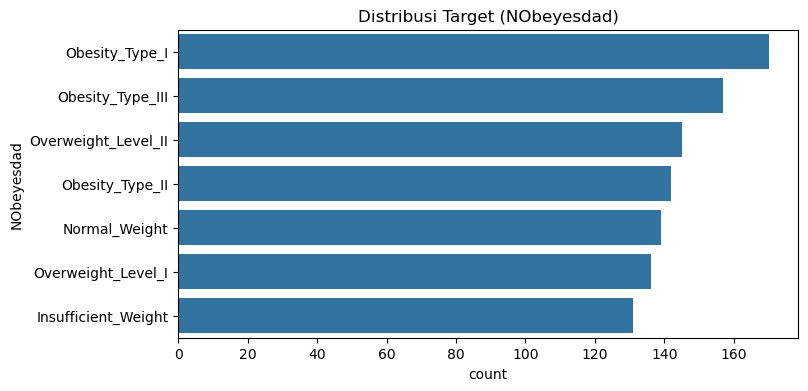

NObeyesdad
Obesity_Type_I         170
Obesity_Type_III       157
Overweight_Level_II    145
Obesity_Type_II        142
Normal_Weight          139
Overweight_Level_I     136
Insufficient_Weight    131
Name: count, dtype: int64


In [10]:
plt.figure(figsize=(8,4))
sns.countplot(y='NObeyesdad', data=df, order=df['NObeyesdad'].value_counts().index)
plt.title('Distribusi Target (NObeyesdad)')
plt.show()
print(df['NObeyesdad'].value_counts())

Disini distribusi target terlihat cukup seimbang, namun saya akan menggunakan stratidy random sampling untuk menjami proporsi kelas target di train dan test tetap sama seperti distribusi asli dataset, mengurangi risiko ada kelas yang hampir/tidak muncul di test/train

## Distribusi Fitur Kategorikal

Gender
Male      513
Female    507
Name: count, dtype: int64


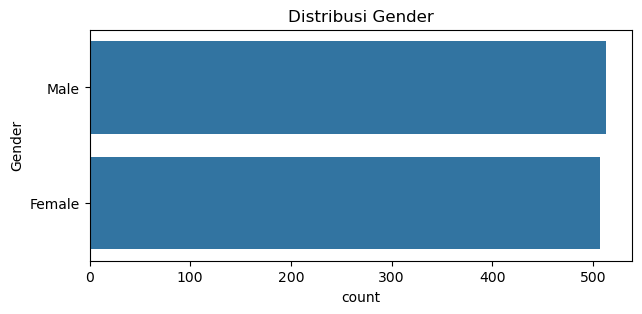

family_history_with_overweight
yes    841
no     179
Name: count, dtype: int64


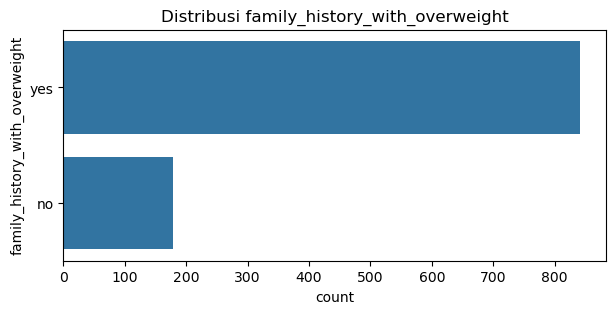

FAVC
yes    897
no     123
Name: count, dtype: int64


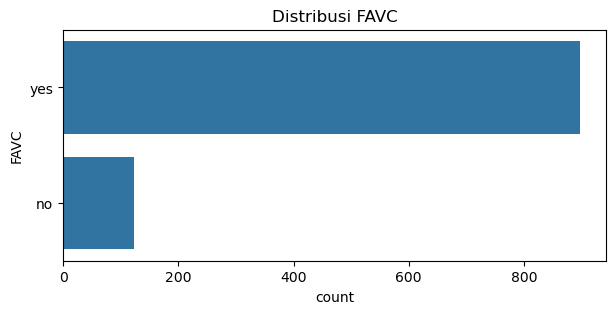

SMOKE
no     998
yes     22
Name: count, dtype: int64


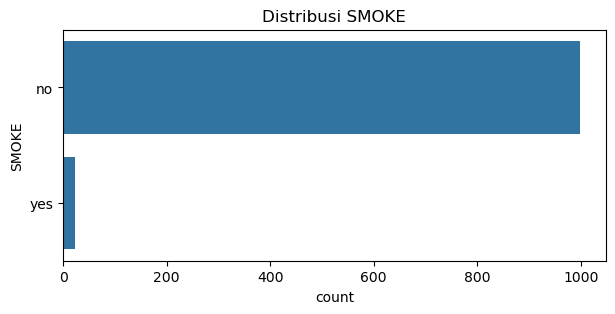

SCC
no     980
yes     40
Name: count, dtype: int64


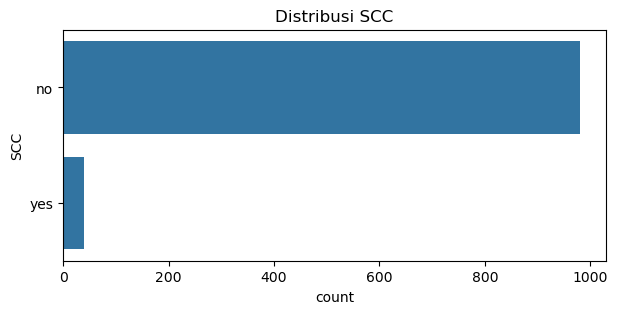

CAEC
Sometimes     870
Frequently    111
Always         24
no             15
Name: count, dtype: int64


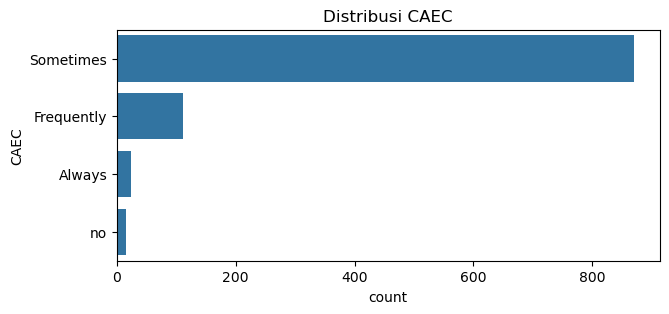

CALC
Sometimes     680
no            302
Frequently     38
Name: count, dtype: int64


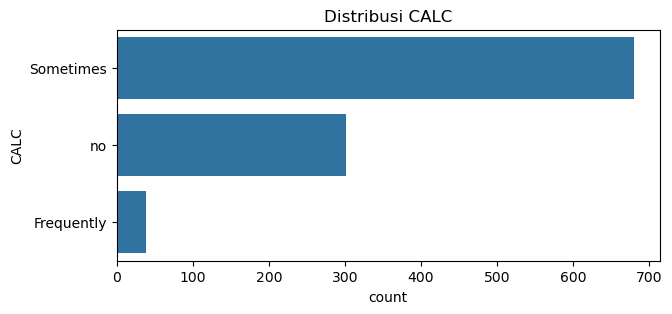

MTRANS
Public_Transportation    757
Automobile               232
Walking                   25
Bike                       3
Motorbike                  3
Name: count, dtype: int64


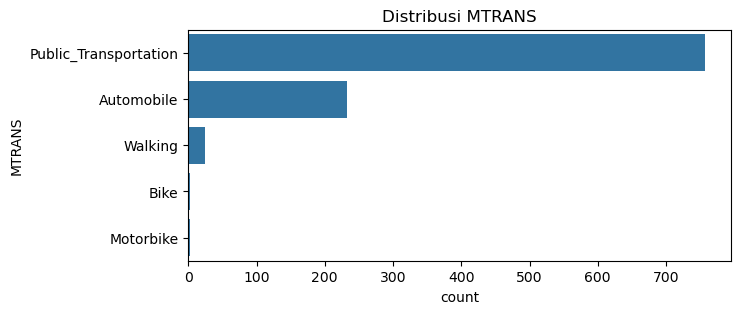

In [11]:
kategori = [
    'Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC',
    'CAEC', 'CALC', 'MTRANS'
]
for col in kategori:
    print(df[col].value_counts())
    plt.figure(figsize=(7,3))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Distribusi {col}')
    plt.show()

## Analisa Distribusi Fitur Kategorikal
### Gender
- Distribusinya hampir 50:50, datanya balance, ga perlu ada penanganan khusus, paling lakukan encoding saja
### Family History With Overweight
- Distribusinya mayoritas *yes* (841) dibanding *no* (179), ini sangat imbalance, tetap gunakan kedua kategorinya, saya akan cek nanti feature importancenya
### FAVC (Frequent high caloric food consumption)
- Distribusinya mayoritas besar *yes* (897) dibanding *no* (123), imbalance lumayan parah. Saya tetap pakai dua kategori, model tree-based tetap aman memposesnya
### SMOKE 
- Distribusinya sangat tidak seimbang, mayoritas *no* (998) hanya 22 orang *yes*. Saya akan pertimbangkan drop fitur ini jika benar-benar tidak informatif setelah cek feature importance/model.
### SCC (Calories consumption monitoring)
- Distribusinya sangat tidak seimbang, mayoritas no (980), hanya 40 orang yes. Hampir seluruh responden tidak melakukan monitoring kalori. Mirip dengan SMOKE. Bisa dipertahankan untuk feature importance, atau drop jika terbukti tidak membantu model.
### CAEC (Eating between meals)
- Distribusinya sangat didominasi Sometimes (870), diikuti Frequently, Always, dan no sangat kecil (15). Saya akan gabung *Always* dan *Frequently* menjadi *Often*. Buat kategori baru: *Never/Sometimes/Often* untuk hasil lebih seimbang.
### CALC (Alcohol consumption)
- Distribusinya didominasi Sometimes (680), lalu no (302), Frequently (38), bisa gabung kategori Frequently dengan Sometimes (jadi Sometimes/Frequently), atau tetap pisah jika ingin analisis lebih detail.
### MTRANS (Transport)
- Distribusinya sangat didominasi Public_Transportation (757), lalu Automobile (232), sisanya minor banget (Walking, Bike, Motorbike <= 25). Gabung kategori minor (Walking, Bike, Motorbike) menjadi satu kategori baru, misal Other atau Active/Other, bisa jadi: Public_Transportation, Automobile, Other.



## Penanganan fitur kategorikal

In [12]:
# CAEC (Gabung kategori minor), gabung 'Always' dan 'Frequently' menjadi 'Often'
# 'no' menjadi 'Never'
df['CAEC'] = df['CAEC'].replace({'Always': 'Often', 'Frequently': 'Often', 'no': 'Never'})

In [13]:
# CALC (Gabung kategori minor), gabung 'Frequently' ke 'Sometimes'
df['CALC'] = df['CALC'].replace({'Frequently': 'Sometimes'})

In [14]:
# MTRANS (Gabung kategori minor), gabung kategori minor menjadi 'Other'
df['MTRANS'] = df['MTRANS'].replace({'Walking': 'Other', 'Bike': 'Other', 'Motorbike': 'Other'})


In [15]:
# Cek hasil penggabungan kategori
for col in ['CAEC', 'CALC', 'MTRANS']:
    print(df[col].value_counts())

CAEC
Sometimes    870
Often        135
Never         15
Name: count, dtype: int64
CALC
Sometimes    718
no           302
Name: count, dtype: int64
MTRANS
Public_Transportation    757
Automobile               232
Other                     31
Name: count, dtype: int64


Gender
Male      513
Female    507
Name: count, dtype: int64


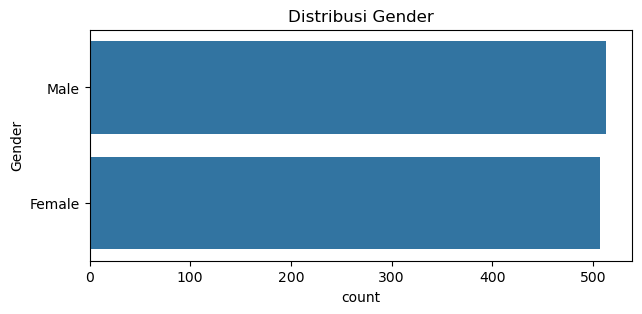

family_history_with_overweight
yes    841
no     179
Name: count, dtype: int64


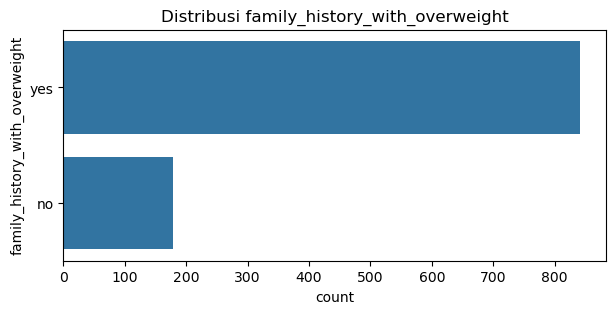

FAVC
yes    897
no     123
Name: count, dtype: int64


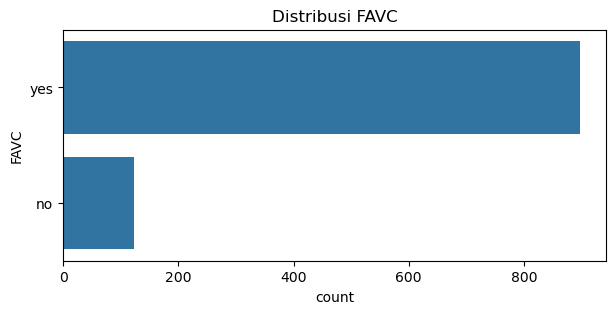

SMOKE
no     998
yes     22
Name: count, dtype: int64


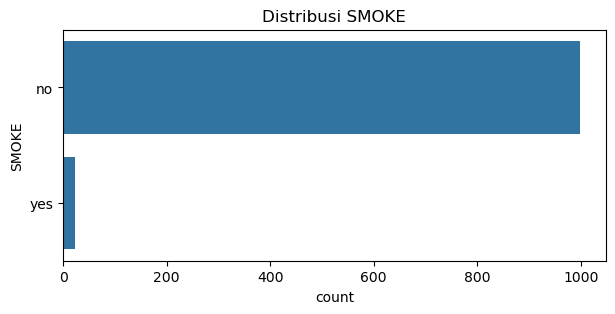

SCC
no     980
yes     40
Name: count, dtype: int64


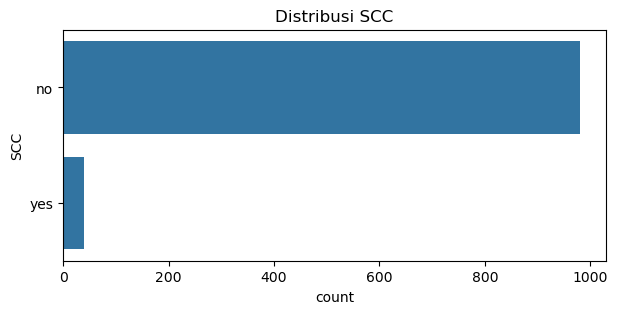

CAEC
Sometimes    870
Often        135
Never         15
Name: count, dtype: int64


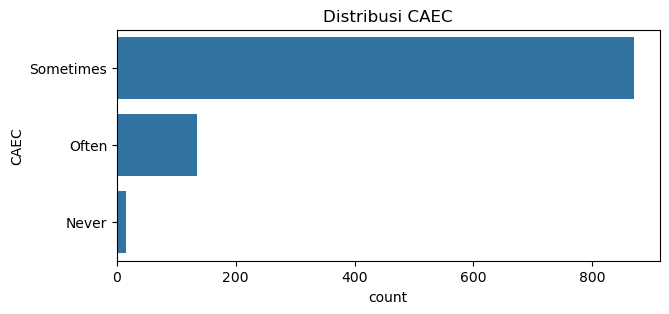

CALC
Sometimes    718
no           302
Name: count, dtype: int64


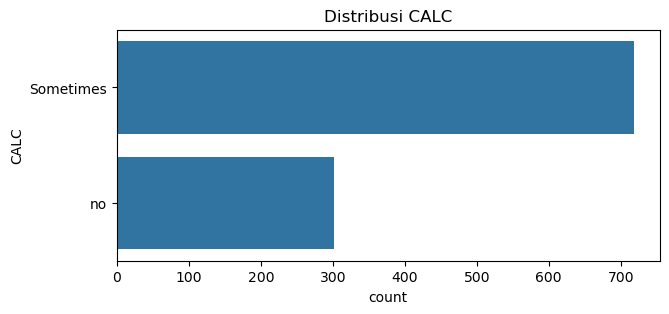

MTRANS
Public_Transportation    757
Automobile               232
Other                     31
Name: count, dtype: int64


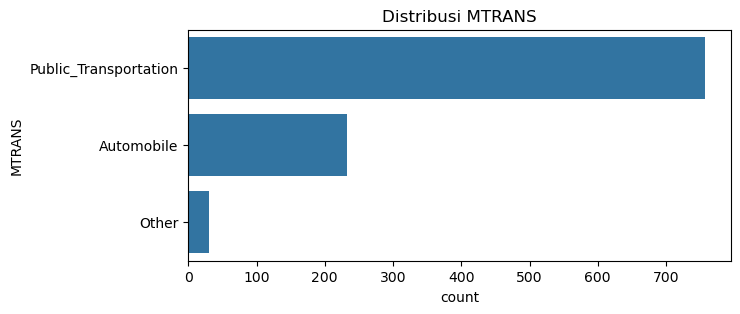

In [16]:
kategori = [
    'Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC',
    'CAEC', 'CALC', 'MTRANS'
]
for col in kategori:
    print(df[col].value_counts())
    plt.figure(figsize=(7,3))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Distribusi {col}')
    plt.show()

**Never** masih minor, tapi tetap informatif (tidak terlalu sedikit hingga harus di-drop). **Sometimes** (gabungan Sometimes & Frequently) 718, **no** 302. Sudah ideal, tidak ada kategori sangat kecil. **Public_Transportation** 757, **Automobile** 232, dan **Other** (gabungan kategori minor) 31. Semua kategori sudah cukup besar, kategori minor sudah digabung.

## Distribusi Fitur Numerik & Analisis Outlier

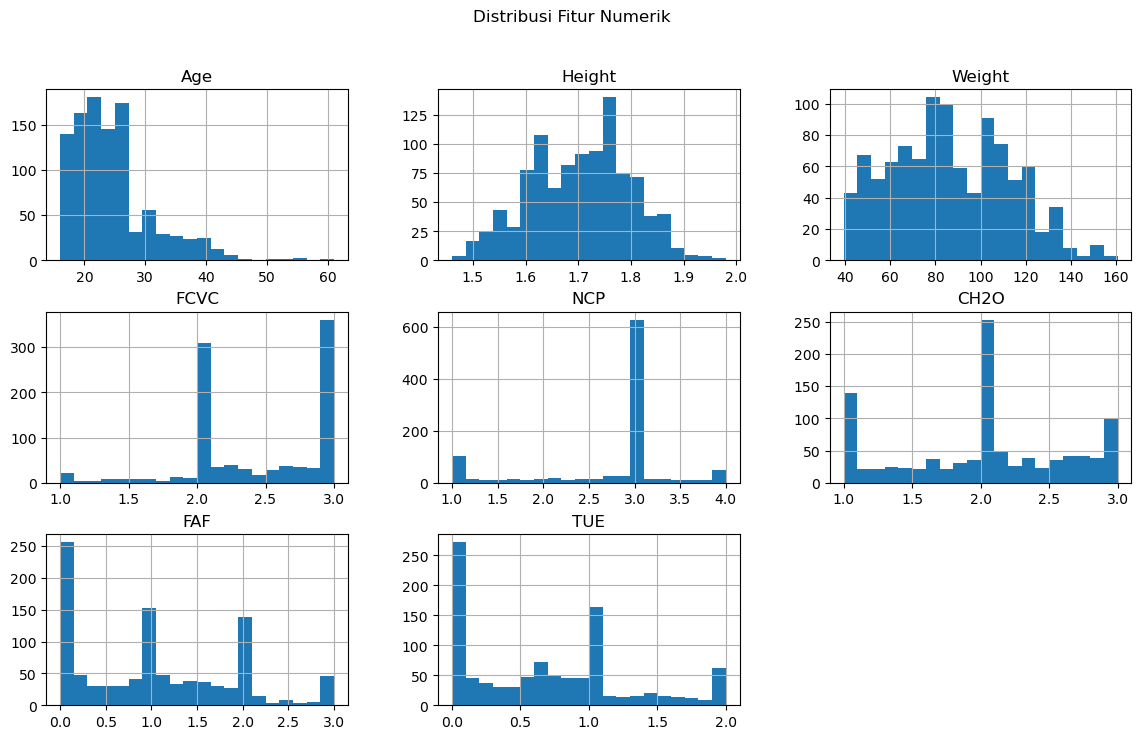

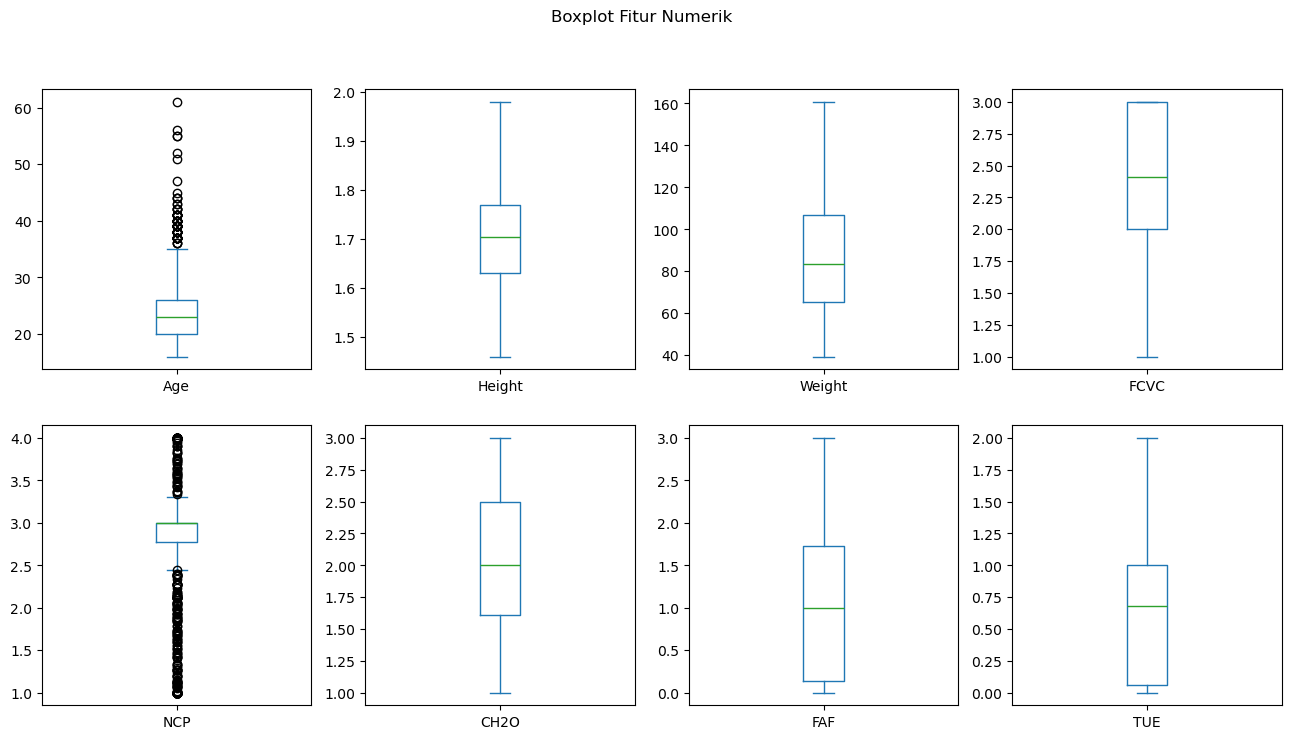

In [17]:
numerik = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
df[numerik].hist(figsize=(14, 8), bins=20)
plt.suptitle('Distribusi Fitur Numerik')
plt.show()

# Boxplot untuk mendeteksi outlier
df[numerik].plot(kind='box', subplots=True, layout=(2,4), figsize=(16,8), sharex=False)
plt.suptitle('Boxplot Fitur Numerik')
plt.show()

## Analisa Distribusi Fitur Numerik
### Age
- Distribusinya skew ke kiri, mayoritas usia 17–30 tahun, ada ekor kanan hingga 60+. Banyak outlier di atas usia 40, saya akan gunakan model base tree supaya efeknya minimal
### Height
- Distribusinya hampir normal, tidak banyak outlier,  hampir tidak ada outlier signifikan, tidak perlu penanganan khusus
### Weight
- Distribusinya hampir normal, sedikit skew ke kanan. Saya akan gunakan model based tree untuk ini.
### SMOKE 
- Distribusinya sangat tidak seimbang, mayoritas *no* (998) hanya 22 orang *yes*. Saya akan pertimbangkan drop fitur ini jika benar-benar tidak informatif setelah cek feature importance/model.
### FCVC (Frequency of consumption of vegetables)
- Distribusinya multimodal, banyak konsentrasi di angka bulat 1, 2, dan 3, hampir tidak ada outlier. Saya akan cek apakah fitur ini secara konsep harus kategori (bukan numerik kontinu), yang mana yang lebih masuk akal nantinya
### NCP (Number of main meals)
- Distribusinya dominan pada nilai bulat (terutama 3), banyak data pada 1 dan 4. Banyak outlier di bawah 2 dan di atas 3. Mirip FCVC, jika semestinya kategori, bisa kita ubah jadi kategori.
### CH2O (Water consumption)
- Distribusinya dominan pada angka bulat (1, 2, 3), distribusi cukup lebar, hampir tidak ada outlier ekstrem, tidak perlu penanganan khusus, scaling cukup.
### FAF (Physical activity frequency)
- Distribusinya dominan di 0, 1, dan 2. Ada sedikit outlier atas, mayoritas masih di bawah 3. Karena sepertinya aku akan pakai model based tree jadi aku ignore.
### TUE (Time using technology devices)
- Distribusinya banyak pada 0, 1, 2, mirip FAF. Hampir tidak ada outlier, distribusi skew ke kiri. Model Based Tree jadi aman



## Fungsi Pengecekan Distribusi & Outlier 

In [18]:
# Fungsi Pengecekan Distribusi & Outlier
def check_numeric_column(df, col, cat_threshold=10, outlier_percentile=(0.01, 0.99), cap_outlier=False, show_info=True):
    """Analisis distribusi, outlier, dan rekomendasi kategori/numerik."""
    x = df[col]
    unique_vals = x.unique()
    nunique = x.nunique()
    skewness = x.skew()
    describe = x.describe()
    outlier_info = ""
    
    # Outlier check
    q1, q3 = x.quantile(0.25), x.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    outliers = ((x < lower) | (x > upper)).sum()
    
    # Cap outlier (tidak aktif default)
    if cap_outlier:
        lower_cap = x.quantile(outlier_percentile[0])
        upper_cap = x.quantile(outlier_percentile[1])
        df[col] = x.clip(lower=lower_cap, upper=upper_cap)
        outlier_info = f" [OUTLIER CAPPED at {outlier_percentile}]"
    
    # Analisis kategori/continuous
    cat_suggestion = ""
    if nunique <= cat_threshold:
        cat_suggestion = " (Disarankan kategori)"
    elif all(np.isclose(unique_vals, np.round(unique_vals))):
        cat_suggestion = " (Cek kemungkinan sebaiknya kategori)"
    
    # Info summary
    if show_info:
        print(f"\n=== {col} ===")
        print(f"Jumlah unique: {nunique} | Skewness: {skewness:.2f}{cat_suggestion}")
        print(describe)
        print(f"Outliers (IQR): {outliers}{outlier_info}")
    return nunique, skewness, outliers

# Analisis Semua Fitur Numerik 
numeric_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
for col in numeric_cols:
    check_numeric_column(df, col, cat_threshold=5, cap_outlier=False)

# Kolom dengan banyak nilai bulat dan unique < threshold: bisa dijadikan kategori
# threshold=5 (NCP, FCVC)
# Ubah ke kategori
for col in ['NCP', 'FCVC']: 
    nunique = df[col].nunique()
    if nunique <= 5:
        df[col] = df[col].astype('category')
        print(f"Kolom {col} diubah ke kategori karena unique values <= 5 ({nunique})")


=== Age ===
Jumlah unique: 36 | Skewness: 1.57 (Cek kemungkinan sebaiknya kategori)
count    1020.000000
mean       24.447059
std         6.422341
min        16.000000
25%        20.000000
50%        23.000000
75%        26.000000
max        61.000000
Name: Age, dtype: float64
Outliers (IQR): 78

=== Height ===
Jumlah unique: 49 | Skewness: -0.07
count    1020.000000
mean        1.703196
std         0.094980
min         1.460000
25%         1.630000
50%         1.705000
75%         1.770000
max         1.980000
Name: Height, dtype: float64
Outliers (IQR): 0

=== Weight ===
Jumlah unique: 736 | Skewness: 0.23
count    1020.000000
mean       86.702392
std        26.157584
min        39.370000
25%        65.137500
50%        83.275000
75%       107.015000
max       160.640000
Name: Weight, dtype: float64
Outliers (IQR): 0

=== FCVC ===
Jumlah unique: 158 | Skewness: -0.46
count    1020.000000
mean        2.425451
std         0.530285
min         1.000000
25%         2.000000
50%         

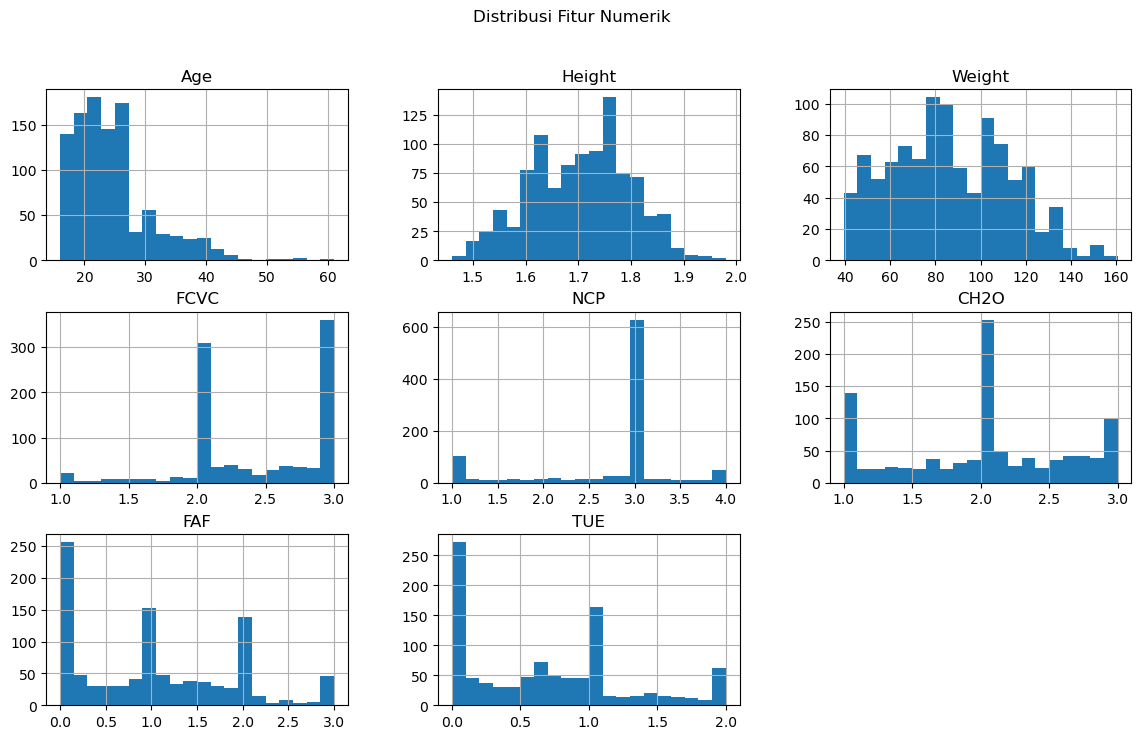

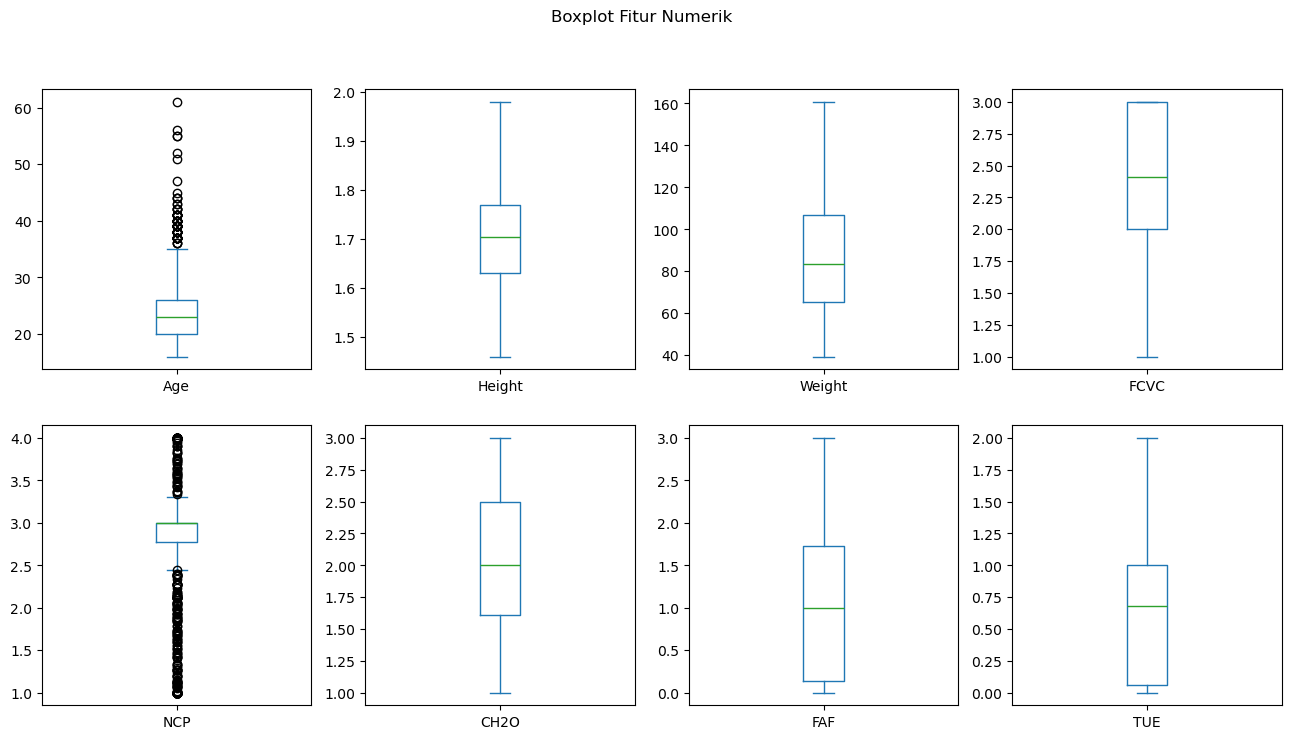

In [19]:
numerik = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
df[numerik].hist(figsize=(14, 8), bins=20)
plt.suptitle('Distribusi Fitur Numerik')
plt.show()

# Boxplot untuk mendeteksi outlier
df[numerik].plot(kind='box', subplots=True, layout=(2,4), figsize=(16,8), sharex=False)
plt.suptitle('Boxplot Fitur Numerik')
plt.show()

Karena saya pakai model based tree, saya tidak jadi gunakan capping, namun bisa jadi kedepannya, saya akan coba lagi, oleh karena itu saya matikan dulu

## Korelasi Fitur Numerik

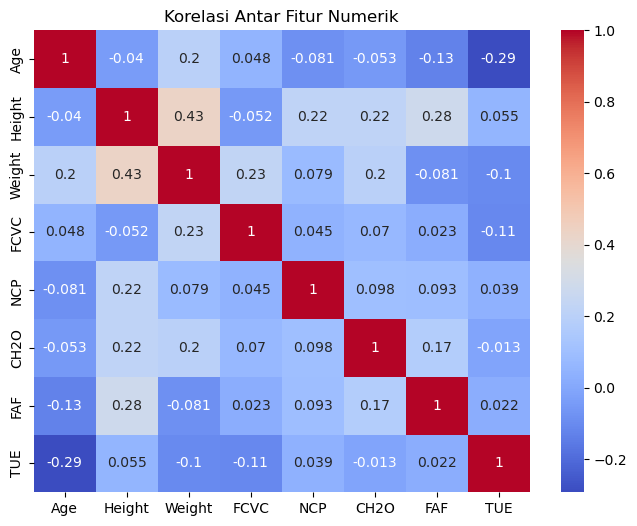

In [20]:
plt.figure(figsize=(8,6))
sns.heatmap(df[numerik].corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Fitur Numerik')
plt.show()

## Insight Korelasi Numerik (Untuk Tree-based Model):
1. Korelasi Rendah (Umumnya < 0.5)
- Mayoritas korelasi antar fitur sangat rendah (nilai |korelasi| < 0.3).
- Hanya Weight & Height yang cukup signifikan (0.43), sisanya rendah bahkan cenderung tidak ada hubungan linear yang kuat.
2. Tidak Ada Multikolinearitas Berat
- Model tree-based tidak terpengaruh multikolinearitas, jadi aku ga akan drop apapaun.
3. Tree-based Model adalah Pilihan yang kupilih
- Model pohon akan memilih split terbaik, bahkan jika fitur saling berkorelasi, model akan memilih mana yang paling informatif di tiap node.


  

## Boxplot Fitur Numerik vs Target

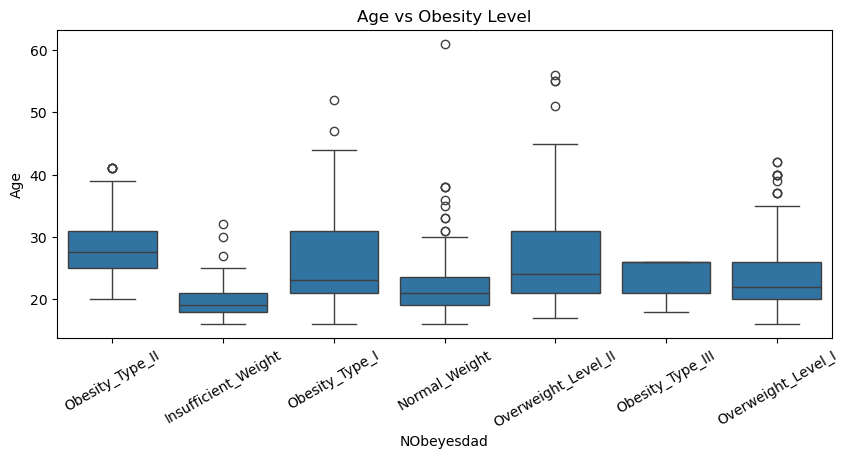

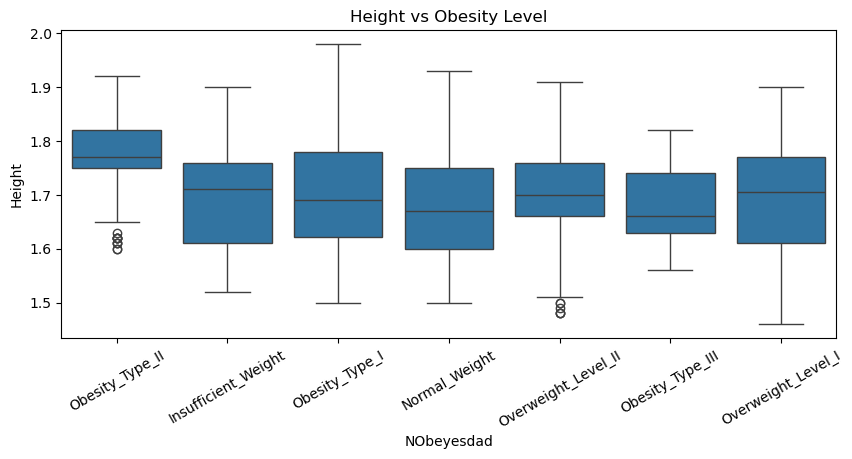

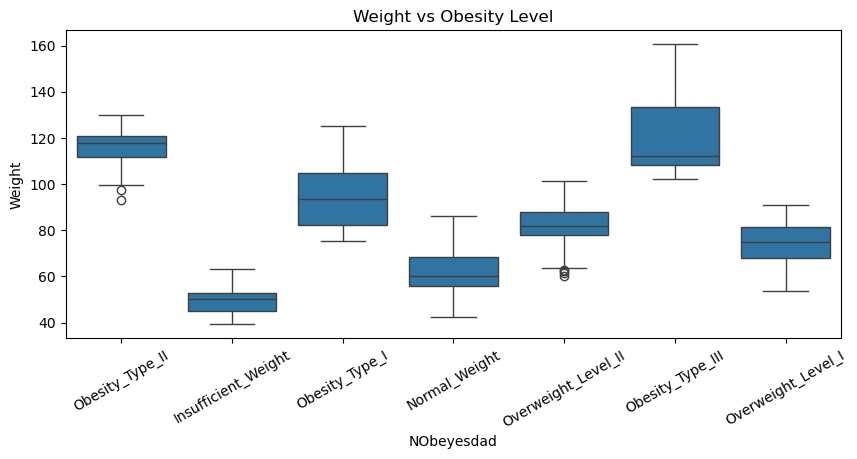

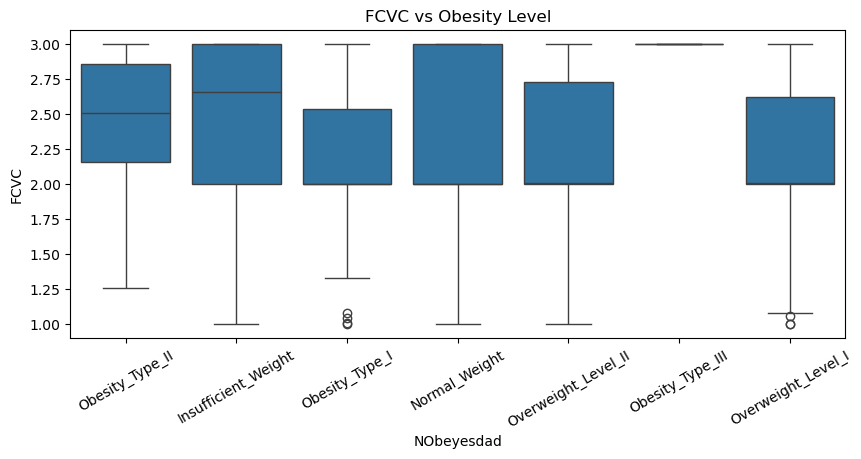

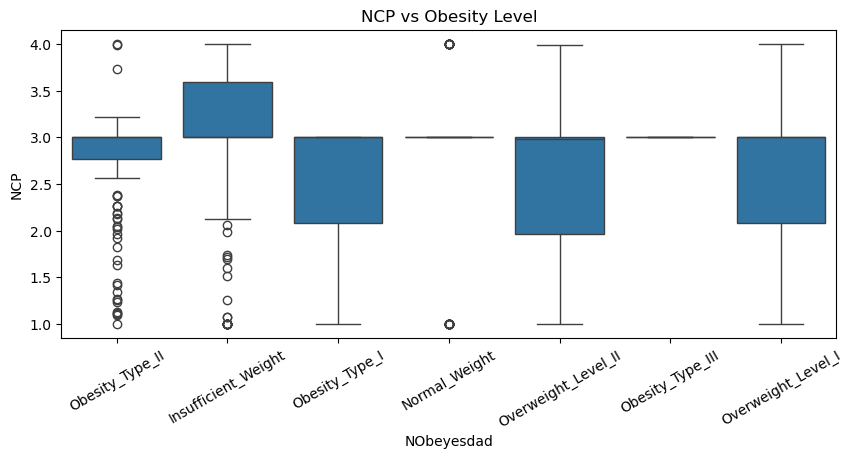

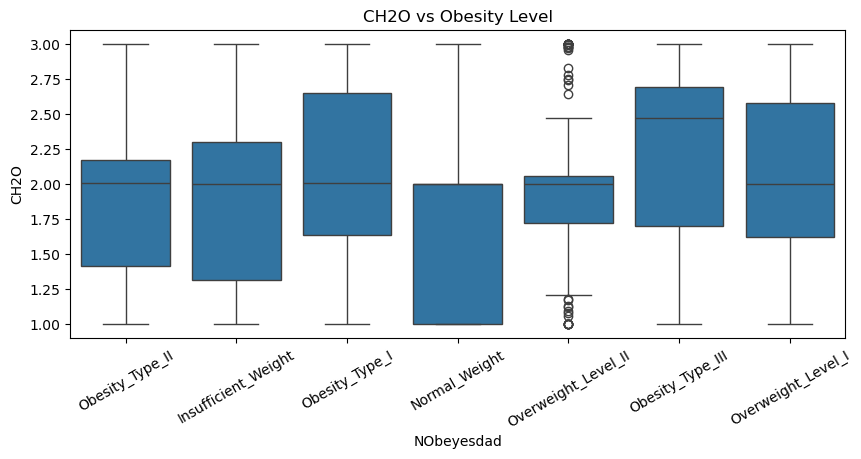

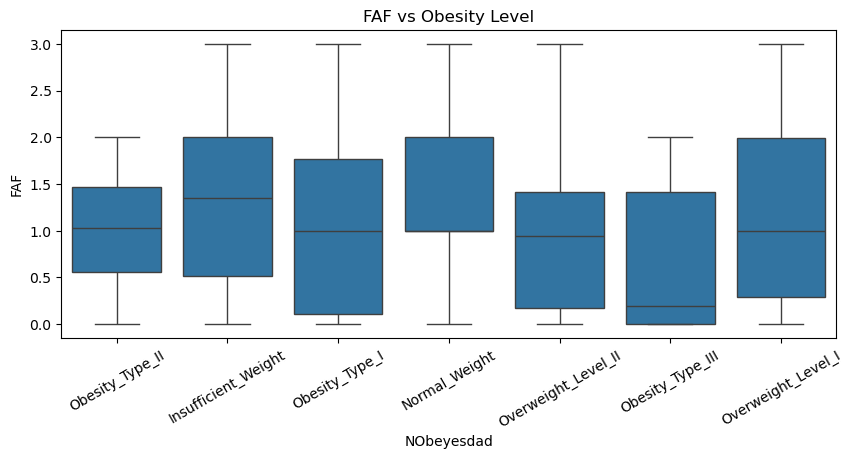

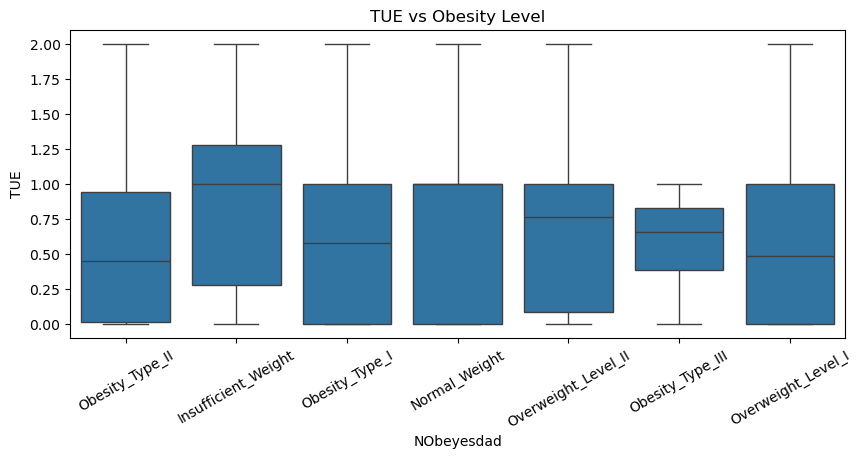

In [21]:
for col in numerik:
    plt.figure(figsize=(10,4))
    sns.boxplot(x='NObeyesdad', y=col, data=df)
    plt.xticks(rotation=30)
    plt.title(f"{col} vs Obesity Level")
    plt.show()

## Analisis per Fitur (Boxplot vs Target)
1. Age vs Obesity Level
- Usia tersebar hampir mirip di tiap kategori obesitas, outlier tidak perlu dibuang (tree-based model robust terhadapnya).
2. Height vs Obesity Level
- Distribusi tinggi badan tidak jauh berbeda di semua kategori obesitas. Tidak tampak pola jelas yang memisahkan kelas. Median cenderung mirip. Tidak perlu scaling khusus untuk tree-based.
3. Weight vs Obesity Level
- Berat badan sangat jelas memisahkan kelas obesitas. Obesity_Type_III paling tinggi, insufficient_weight paling rendah, kelas lain berurutan sesuai urutan medisnya. Fitur sangat penting, tetap gunakan apa adanya.
4. FCVC (Vegetable Consumption Frequency) vs Obesity Level
- Sebagian besar kategori punya median di atas 2. Insufficient_weight dan obesity cenderung di bawah normal/overweight. Namun, distribusinya cenderung rata-rata tinggi (banyak yang makan sayur cukup sering). Tidak perlu scaling khusus untuk tree-based.
5. NCP (Number of Meals per Day) vs Obesity Level
- Hampir semua kategori punya median 3. Insufficient_weight punya variasi lebih lebar. Obesity cenderung 3. Variasi keluar, tapi tidak terlalu memisahkan. Tidak ada outlier signifikan yang perlu dibuang.
6. CH2O (Water Intake) vs Obesity Level
- Median minum air sekitar 2 di hampir semua kategori. Terdapat outlier, tapi tidak terlalu banyak. Tidak tampak perbedaan besar antar kelas. Tidak perlu buang outlier.
7. FAF (Physical Activity Frequency) vs Obesity Level
- Median aktivitas fisik lebih rendah di Obesity_Type_III, tapi variasinya besar, overlap masih banyak. Tidak perlu scaling khusus untuk tree-based.
8. TUE (Time Using Tech Devices) vs Obesity Level
- Hampir semua kategori punya distribusi serupa, sedikit lebih tinggi pada insufficient_weight. Karena pakai model based tree, aku ignore saja, tree yang decide.

## Korelasi Fitur Kategorikal

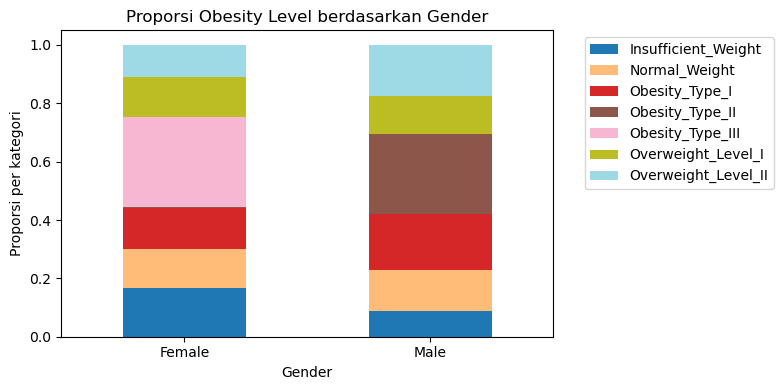

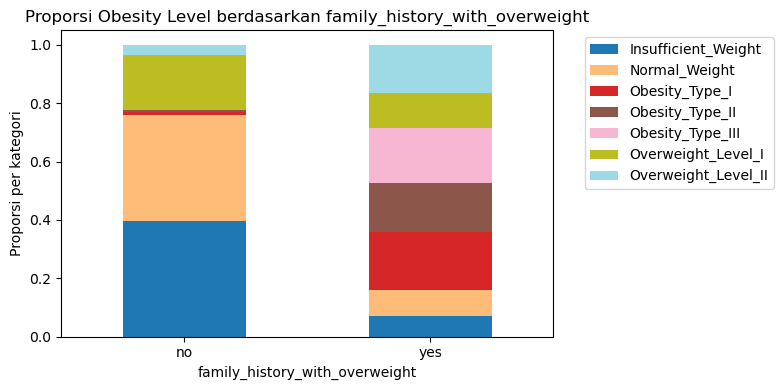

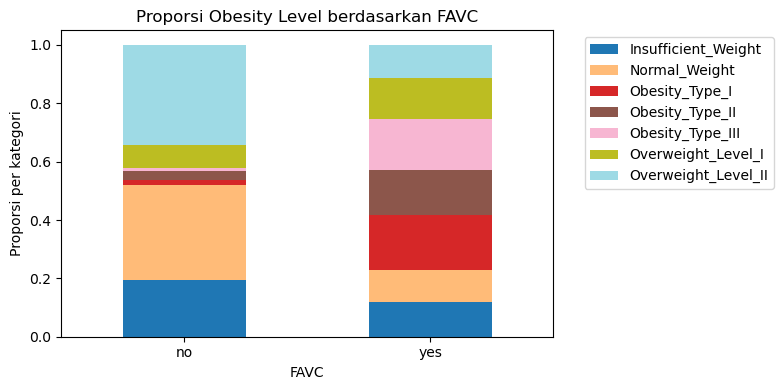

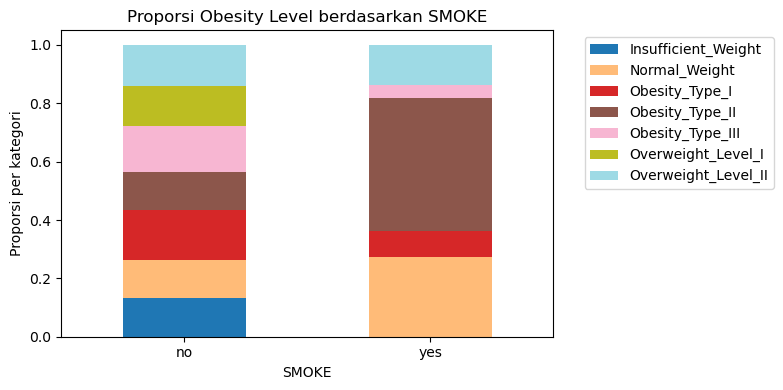

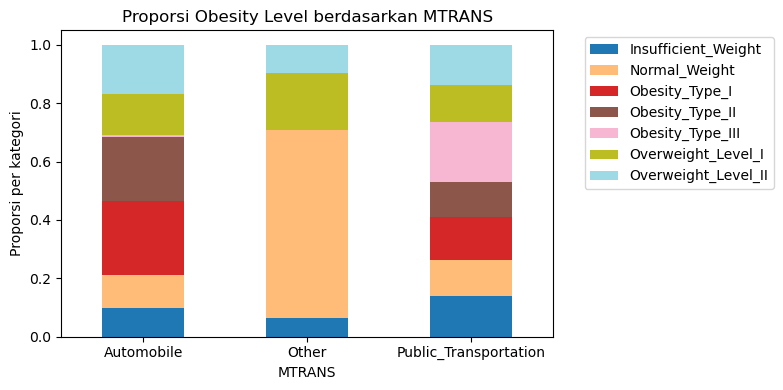

In [22]:
# Crosstab Fitur Kategorikal vs Target (Stacked Bar)
cat_for_crosstab = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'MTRANS']

for col in cat_for_crosstab:
    ctab = pd.crosstab(df[col], df['NObeyesdad'], normalize='index')
    ctab.plot(kind='bar', stacked=True, figsize=(8,4), colormap='tab20')
    plt.title(f"Proporsi Obesity Level berdasarkan {col}")
    plt.ylabel("Proporsi per kategori")
    plt.xticks(rotation=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


Analisa Fitur Kategorikal:
1. Gender
- Proporsi tingkat obesitas cukup mirip antara laki-laki dan perempuan, tapi pria tampak punya proporsi sedikit lebih tinggi pada kategori Obesity Type II & Overweight Level II. Wanita cenderung lebih banyak pada Obesity Type III. Aku tetap guanakan fitur Gender, meski pengaruhnya sedang. Tree-based model bisa deteksi pengaruh bahkan jika tidak sangat besar.
2. Family History With Overweight
- Responden dengan riwayat keluarga overweight ("yes") punya distribusi proporsi yang lebih **merata** ke semua kelas obesitas, proporsi obesitas jelas lebih tinggi dibanding yang "no". No family history didominasi Insufficient dan Normal Weight. Fitur sangat informatif, jadi aku pertahankan.
3. FAVC (Frequent High Caloric Food Consumption)
- Pada yes, kelas overweight dan obesity jelas lebih tinggi proporsinya dibanding no. Pada no, proporsi Normal Weight dan Overweight Level II mendominasi. Meski imbalance, pengaruhnya pada target signifikan dan tree-based tetap bisa eksploitasi hubungan ini.
4. SMOKE
- Mayoritas responden tidak merokok. Yang yes cenderung punya proporsi lebih tinggi pada Obesity Type II, tapi jumlahnya kecil (data minor). Karena pakai model based tree, aku biarkan.
5. MTRANS (Transportasi)
- Penggabungan kategori minor sudah tepat.


# Data Preprocessing

## Encoding Fitur Kategorikal

In [23]:
# Identifikasi fitur kategorikal dan numerik
categorical = [
    'Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC',
    'CAEC', 'CALC', 'MTRANS'
]
numerical = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

Fitur- fitur akan kupisahkan menjadi categorical dan numerical, saya menggunakan One-Hot Encoding untuk mengubah masing-masing kategori menjadi variabel dummy agar dapat digunakan dalam model machine learning.

## One-Hot Encoding untuk fitur kategorikal

In [24]:
# Cek unique values dulu untuk tentukan LabelEncoder/OneHotEncoder
for col in categorical:
    print(f"{col}: {df[col].unique()}")

Gender: ['Male' 'Female']
family_history_with_overweight: ['yes' 'no']
FAVC: ['yes' 'no']
SMOKE: ['yes' 'no']
SCC: ['no' 'yes']
CAEC: ['Sometimes' 'Often' 'Never']
CALC: ['Sometimes' 'no']
MTRANS: ['Automobile' 'Public_Transportation' 'Other']


# Label Encoding untuk target/label

In [25]:
df_encoded = pd.get_dummies(df, columns=categorical, drop_first=True, dtype=int)
df_encoded.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,Gender_Male,family_history_with_overweight_yes,FAVC_yes,SMOKE_yes,SCC_yes,CAEC_Often,CAEC_Sometimes,CALC_no,MTRANS_Other,MTRANS_Public_Transportation
0,31,1.87,128.87,2.96,3.00,1.28,0.90,1.875,Obesity_Type_II,1,1,1,1,0,0,1,0,0,0
1,18,1.59,40.00,2.00,1.00,1.00,0.00,2.000,Insufficient_Weight,0,1,1,0,0,1,0,1,0,1
2,44,1.59,77.00,2.00,3.00,2.81,0.00,0.000,Obesity_Type_I,0,1,1,0,0,0,1,0,0,0
3,31,1.68,102.00,2.94,2.14,1.25,1.18,0.778,Obesity_Type_II,1,1,1,0,0,0,1,1,0,1
4,22,1.74,75.00,3.00,3.00,1.00,1.00,0.000,Normal_Weight,1,1,1,0,0,1,0,1,0,0


In [26]:
le = LabelEncoder()
df_encoded['NObeyesdad'] = le.fit_transform(df_encoded['NObeyesdad']).astype(int)

# Cek hasil encode
df_encoded.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,Gender_Male,family_history_with_overweight_yes,FAVC_yes,SMOKE_yes,SCC_yes,CAEC_Often,CAEC_Sometimes,CALC_no,MTRANS_Other,MTRANS_Public_Transportation
0,31,1.87,128.87,2.96,3.00,1.28,0.90,1.875,3,1,1,1,1,0,0,1,0,0,0
1,18,1.59,40.00,2.00,1.00,1.00,0.00,2.000,0,0,1,1,0,0,1,0,1,0,1
2,44,1.59,77.00,2.00,3.00,2.81,0.00,0.000,2,0,1,1,0,0,0,1,0,0,0
3,31,1.68,102.00,2.94,2.14,1.25,1.18,0.778,3,1,1,1,0,0,0,1,1,0,1
4,22,1.74,75.00,3.00,3.00,1.00,1.00,0.000,1,1,1,1,0,0,1,0,1,0,0


## Pisah X dan y

In [27]:
X = df_encoded.drop('NObeyesdad', axis=1)
y = df_encoded['NObeyesdad']

## Train-Test Split dengan Stratify

In [28]:
# Stratify supaya distribusi label tetap seimbang di train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Disini aku pakai stratify agar distribusi label data train dan test tetap seimbang. Tanpa stratify bisa saja label tidak proporsional (misal kelas "Obesity_Type_III" hanya muncul di test). Dengan stratify, proporsi tiap kelas sama antara train dan test, sehingga evaluasi model lebih fair dan tidak bias terhadap kelas mayoritas.

## Standarisasi hanya untuk fitur numerik

In [29]:
# Inisialisasi scaler
scaler = StandardScaler()

# Fit hanya ke data training
X_train[numerical] = scaler.fit_transform(X_train[numerical])

# Transform ke data test (tanpa fit ulang)
X_test[numerical] = scaler.transform(X_test[numerical])


### Scaling Fitur Numerik
Di sini saya melakukan standarisasi agar data menjadi zero-centered, yaitu memiliki rata-rata (mean) 0 dan standar deviasi 1 untuk mengilankan bias skala antar fitur dan mempercepat konvergensi saat proses pelatihan

## Cek hasil akhir

In [30]:
# Cek beberapa baris pertama hasil preprocessing
print(X_train.head())
print(X_test.head())
print(y_train.value_counts(normalize=True))

          Age    Height    Weight      FCVC       NCP      CH2O       FAF  \
528 -0.533022  1.041008  0.653343 -0.807064  0.377073  0.635782  2.185256   
596 -0.227475  0.191970 -0.175179 -0.807064 -2.268486 -1.669623 -0.032149   
280  0.689165 -1.824496 -0.822808 -0.807064 -2.268486 -1.669623 -0.900339   
574 -0.074702  0.191970 -0.099234 -0.026865  0.165428 -0.055839 -0.184669   
270 -0.838568 -0.020290 -0.263718  0.601101 -0.734061 -1.521418 -1.076323   

          TUE  Gender_Male  family_history_with_overweight_yes  FAVC_yes  \
528 -1.151661            1                                   1         1   
596  0.510521            1                                   1         1   
280 -1.151661            0                                   1         0   
574 -1.003727            1                                   1         1   
270 -1.145012            1                                   1         0   

     SMOKE_yes  SCC_yes  CAEC_Often  CAEC_Sometimes  CALC_no  MTRANS_Other  \
52

In [31]:
df_encoded.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,Gender_Male,family_history_with_overweight_yes,FAVC_yes,SMOKE_yes,SCC_yes,CAEC_Often,CAEC_Sometimes,CALC_no,MTRANS_Other,MTRANS_Public_Transportation
0,31,1.87,128.87,2.96,3.00,1.28,0.90,1.875,3,1,1,1,1,0,0,1,0,0,0
1,18,1.59,40.00,2.00,1.00,1.00,0.00,2.000,0,0,1,1,0,0,1,0,1,0,1
2,44,1.59,77.00,2.00,3.00,2.81,0.00,0.000,2,0,1,1,0,0,0,1,0,0,0
3,31,1.68,102.00,2.94,2.14,1.25,1.18,0.778,3,1,1,1,0,0,0,1,1,0,1
4,22,1.74,75.00,3.00,3.00,1.00,1.00,0.000,1,1,1,1,0,0,1,0,1,0,0


Sudah distandarisasi (StandardScaler), meskipun untuk tree-based tidak wajib. Kategorikal sudah di-one-hot encode. Semua kelas target masih terwakili dengan baik setelah split, tidak ada kelas yang hilang atau terlalu timpang (masih di atas 12% semua), jadi tidak perlu resampling saat ini.

# Model Training

## Random Forest

### Hyperparameter grid

In [32]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],   # Jumlah pohon dalam Random Forest; lebih banyak pohon bisa meningkatkan akurasi tapi juga waktu komputasi
    'max_depth': [None, 10, 20, 30],  # Kedalaman maksimum pohon; None berarti pohon akan tumbuh sampai daun murni
    'min_samples_split': [2, 5, 10],  # Jumlah minimum sampel yang dibutuhkan untuk membagi node
    'min_samples_leaf': [1, 2, 4],   # Jumlah minimum sampel yang harus ada di setiap daun
    'class_weight': [None, 'balanced']  # Coba tambahkan penanganan imbalance
}

### Inisialisasi model

In [33]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1) # n_jobs=-1 untuk memaksimalkan semua core CPU

In [34]:
# GridSearchCV
gs_rf = GridSearchCV(
    rf,
    param_grid=param_grid_rf,  # Grid hyperparameter yang akan dieksplorasi
    cv=5,  # Menggunakan 5-Fold Cross Validation
    scoring='f1_macro',  # Karena klasifikasi multikelas dan mempertimbangkan ketidakseimbangan kelas
    verbose=2,
    n_jobs=-1
)

Untuk metric evaluasi, saya menggunakan **`f1_macro`** saat hyperparameter tuning karena klasifikasi bersifat multikelas dan relatif imbalanced.  
Pada tahap evaluasi akhir, saya tetap menampilkan **accuracy, precision, recall, dan f1-score** dari `classification_report`, serta `confusion_matrix` untuk melihat performa setiap kelas lebih detail.


### Train model

In [35]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


## Model Evaluation

In [36]:
# Output hasil terbaik
print("Best RF Params:", gs_rf.best_params_)
print("Best Cross-Validation F1_macro:", gs_rf.best_score_)

Best RF Params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation F1_macro: 0.9375182003763415


In [37]:
# Evaluasi pada data test
y_pred_rf = gs_rf.predict(X_test)

In [38]:
print("Classification Report (Random Forest)")
print(classification_report(y_test, y_pred_rf))

Classification Report (Random Forest)
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        26
           1       0.75      0.96      0.84        28
           2       0.97      0.94      0.96        34
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        31
           5       0.96      0.81      0.88        27
           6       0.93      0.86      0.89        29

    accuracy                           0.93       204
   macro avg       0.93      0.92      0.92       204
weighted avg       0.93      0.93      0.93       204



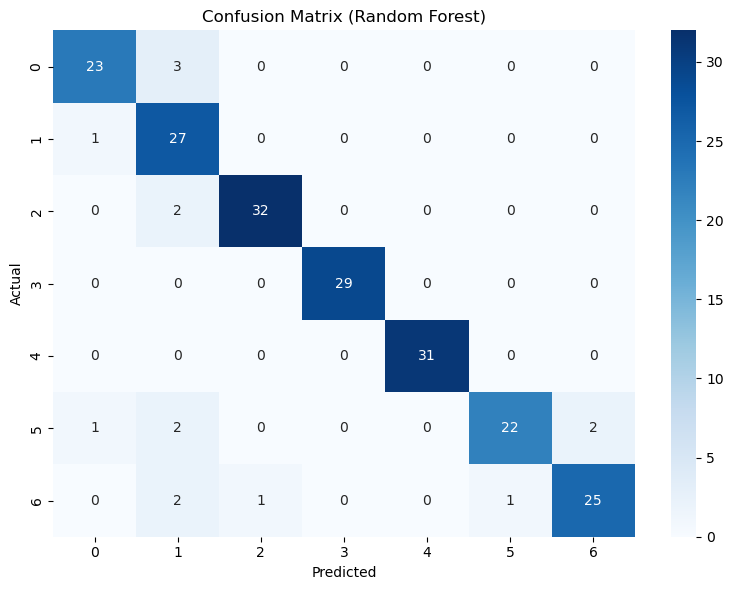

In [39]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')
plt.tight_layout()
plt.show()

In [40]:
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='macro'))
print("Recall   :", recall_score(y_test, y_pred_rf, average='macro'))
print("F1-score :", f1_score(y_test, y_pred_rf, average='macro'))

Accuracy : 0.9264705882352942
Precision: 0.9317349478219042
Recall   : 0.9238516214030558
F1-score : 0.9248274011096976


###  Tabel Evaluasi Model (Random Forest)

| **Metric**   | **Nilai** | **Interpretasi** |
|--------------|-----------|------------------|
| **Accuracy** | 0.9264    | Model memprediksi dengan benar sekitar **92.64%** dari seluruh data uji |
| **Precision**| 0.9317    | Dari semua prediksi, **93.17%** adalah benar-benar sesuai dengan label asli |
| **Recall**   | 0.9239    | Dari semua label asli yang ada, **92.39%** berhasil ditemukan oleh model |
| **F1-score** | 0.9248    | Harmoni antara Precision dan Recall, cocok untuk data yang tidak seimbang, hasilnya **92.48%** |


## XgBoost

### Hyperparameter Grid

In [41]:
# Hyperparameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 300],        # Banyaknya pohon boosting
    'max_depth': [3, 6, 10],                # Batas kedalaman pohon
    'learning_rate': [0.01, 0.1, 0.2],      # Ukuran langkah boosting
    'subsample': [0.7, 0.8, 1.0],           # Proporsi data yang digunakan tiap boosting round
    'colsample_bytree': [0.7, 0.8, 1.0],    # Proporsi fitur yang digunakan tiap pohon
    'gamma': [0, 0.1, 0.5]                  # Minimum loss reduction agar split dilakukan
}

### Insialisasi Model

In [42]:
xgb = XGBClassifier(random_state=42, eval_metric='mlogloss', n_jobs=-1)

In [43]:
# Grid SearchCV
gs_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,  # grid dari cell sebelumnya
    cv=5,                        # Cross-validation 5 fold
    scoring='f1_macro',         # Fokus pada f1_macro karena kelas seimbang
    verbose=2,                  # Lihat progress training
    n_jobs=-1                   # Gunakan semua core CPU
)


### Train Model

In [44]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    gs_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


## Model Evaluation

In [45]:
# Output hasil terbaik
print("Best XGB Params:", gs_xgb.best_params_)
print("Best Cross-Validation F1_macro:", gs_xgb.best_score_)


Best XGB Params: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 1.0}
Best Cross-Validation F1_macro: 0.9579523628315162


In [46]:
# Evaluasi pada data test
y_pred_xgb = gs_xgb.predict(X_test)


In [47]:
# Classification Report
print("Classification Report (XGBoost)")
print(classification_report(y_test, y_pred_xgb))


Classification Report (XGBoost)
              precision    recall  f1-score   support

           0       0.96      0.88      0.92        26
           1       0.73      0.86      0.79        28
           2       0.97      0.97      0.97        34
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        31
           5       0.88      0.78      0.82        27
           6       0.90      0.90      0.90        29

    accuracy                           0.92       204
   macro avg       0.92      0.91      0.91       204
weighted avg       0.92      0.92      0.92       204



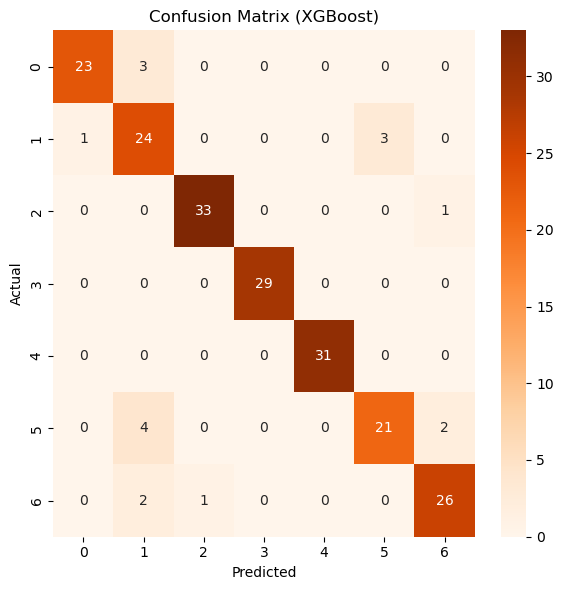

In [48]:
# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost)')
plt.tight_layout()
plt.show()


In [49]:
# Metrik Evaluasi
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, average='macro'))
print("Recall   :", recall_score(y_test, y_pred_xgb, average="macro"))
print("F1-score :", f1_score(y_test, y_pred_xgb, average="macro"))


Accuracy : 0.9166666666666666
Precision: 0.9182494314340156
Recall   : 0.912382282709724
F1-score : 0.9139363738711991


### Tabel Evaluasi Model (XGBoost)

| **Metric**   | **Nilai** | **Interpretasi** |
|--------------|-----------|------------------|
| **Accuracy** | **0.9107** | Model memprediksi dengan benar sekitar **91.07%** dari seluruh data uji |
| **Precision**| **0.9182** | Dari semua prediksi, **91.82%** adalah benar-benar sesuai dengan label asli |
| **Recall**   | **0.9123** | Dari semua label asli yang ada, **91.23%** berhasil ditemukan oleh model |
| **F1-score** | **0.9139** | Harmoni antara Precision dan Recall, cocok untuk data yang tidak seimbang, hasilnya **91.39%** |


## Perbandingan Kedua Model

In [50]:
# Hitung metrik untuk Random Forest
rf_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf, average='macro'),
    'Recall': recall_score(y_test, y_pred_rf, average='macro'),
    'F1-score': f1_score(y_test, y_pred_rf, average='macro')
}

# Hitung metrik untuk XGBoost
xgb_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb, average='macro'),
    'Recall': recall_score(y_test, y_pred_xgb, average='macro'),
    'F1-score': f1_score(y_test, y_pred_xgb, average='macro')
}

# Buat dataframe perbandingan
comparison_df = pd.DataFrame([rf_metrics, xgb_metrics], index=['Random Forest', 'XGBoost'])
print(comparison_df)

               Accuracy  Precision    Recall  F1-score
Random Forest  0.926471   0.931735  0.923852  0.924827
XGBoost        0.916667   0.918249  0.912382  0.913936


Random Forest unggul di semua metrik utama (accuracy, precision, recall, dan f1-score) dibandingkan XGBoost, meskipun perbedaannya tidak terlalu besar. Kinerja Random Forest yang lebih stabil tanpa perlu banyak tuning menjadikannya pilihan yang lebih praktis dan efektif untuk kasus ini. Oleh karena itu, saya memilih Random Forest sebagai model final karena memberikan hasil terbaik secara keseluruhan serta interpretasi yang lebih sederhana.

In [51]:
# Buat model dengan parameter terbaik (Random Forest)
best_model = RandomForestClassifier(
    class_weight='balanced',
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

# Fit model ke data training final
best_model.fit(X_train, y_train)

# Simpan model ke dalam file pickle
with open("best_model.pkl", "wb") as file:
    pickle.dump(best_model, file)

pkl sementara telah dibuat untuk data prosedural